In [1]:
from tensorflow.keras.layers import Input,Dense,LSTM,Flatten
from tensorflow.keras.models import Model


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import MetaTrader5 as mt5
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.45


In [5]:
markets = ["AUDUSD","EURUSD","GBPUSD","USDCAD","USDCHF","XAUUSD","NZDUSD"]
if not mt5.initialize():
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')

else: 
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())

{'login': 75525372, 'trade_mode': 0, 'leverage': 100, 'limit_orders': 200, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 59.04, 'credit': 0.0, 'profit': 0.0, 'equity': 59.04, 'margin': 0.0, 'margin_free': 59.04, 'margin_level': 0.0, 'margin_so_call': 50.0, 'margin_so_so': 30.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'mike bright', 'server': 'MetaQuotes-Demo', 'currency': 'USD', 'company': 'MetaQuotes Software Corp.'}


{'community_account': True, 'community_connection': True, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': False, 'build': 4076, 'maxbars': 100000, 'codepage': 0, 'ping_last': 153856, 'community_balance': 0.0, 'retransmission': 0.5975475652011536, 'company': 'MetaQuotes Sof

In [8]:
n = 2
rates = mt5.copy_rates_from_pos(markets[n], mt5.TIMEFRAME_H4, 0, 99999)
#print(rates)
print(rates.shape)
x = []
y = []


for i in range(len(rates)):
    x.append([rates[i][1],rates[i][5]])
    y.append(rates[i][4])


x = np.array(x)
y = np.array(y)



(40277,)


In [4]:
#Experiment
print(mt5.Close("XAUUSD"))

True


In [9]:
print(x)
print(y)

print(x.shape)
print(y.shape)

[[1.53700e+00 2.78100e+03]
 [1.53280e+00 2.57100e+03]
 [1.52280e+00 2.71100e+03]
 ...
 [1.26527e+00 5.91500e+03]
 [1.26443e+00 8.06600e+03]
 [1.26680e+00 4.55800e+03]]
[1.5338  1.5225  1.5387  ... 1.26443 1.26679 1.2639 ]
(40277, 2)
(40277,)


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.03, random_state=0)


x_test = x_test[:-100]
y_test = y_test[:-100]



print(x_train.shape)
print(x_test.shape)



(39068, 2)
(1109, 2)


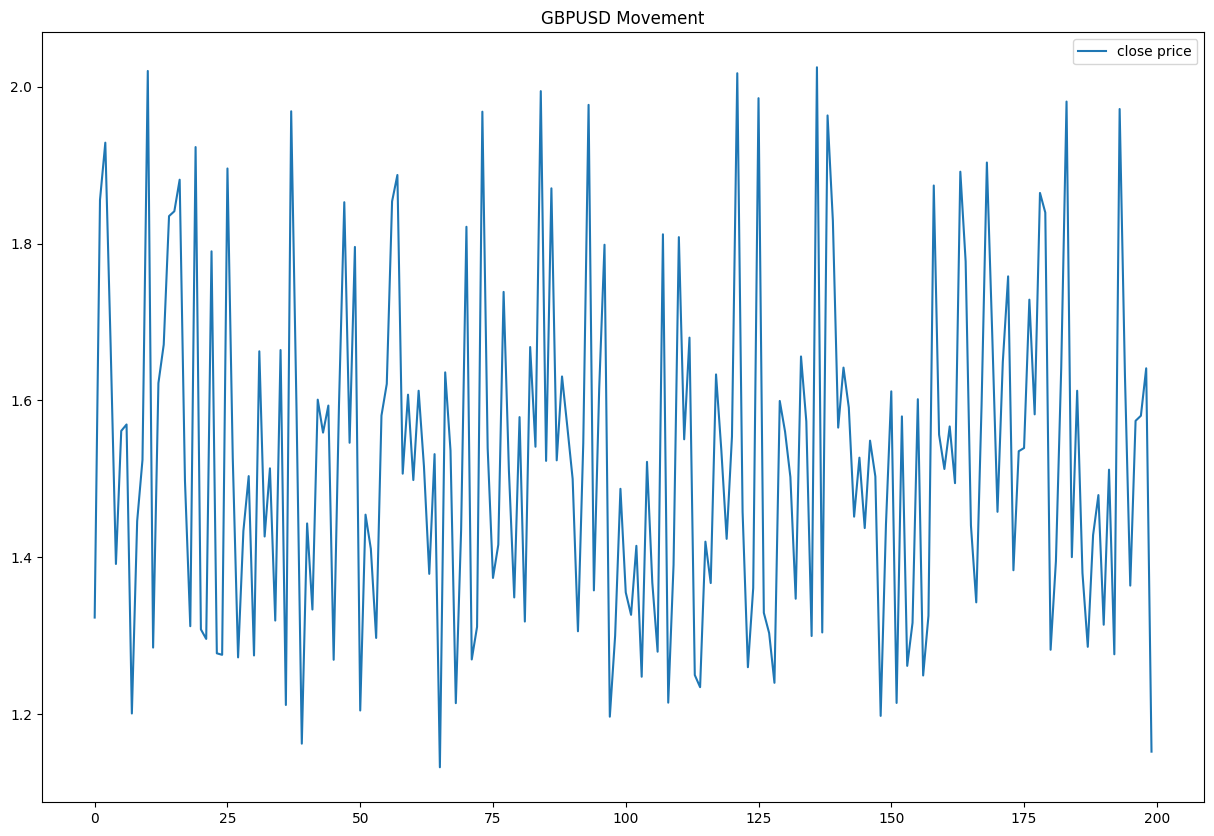

In [11]:
plt.figure(figsize=(15, 10))
plt.title(markets[n]+' Movement')
plt.plot(y_test[-200:], label="close price")
#plt.plot(x_test[-200:], label="open price")
plt.legend()
plt.show()

In [12]:
sc_x = StandardScaler()
sc_y = StandardScaler()

x_train = sc_x.fit_transform(x_train)
y_train = sc_y.fit_transform(y_train.reshape((len(y_train),1)))
y_train = y_train.reshape(-1)

x_test = sc_x.transform(x_test)
y_test = sc_y.transform(y_test.reshape((len(y_test),1)))
y_test = y_test.reshape(-1)
print(x_train)
print(y_train)




[[-1.40330022 -0.54680587]
 [ 0.5942178  -0.62607077]
 [-0.44824363  0.64307408]
 ...
 [-1.09486199  1.72075441]
 [ 0.27494736  1.41507592]
 [ 0.55499768 -0.80001039]]
[-1.39861068  0.61786208 -0.46078369 ... -1.07551187  0.26016555
  0.56183338]


In [13]:
timesteps = 1
samples = x_train.shape[0]
features = x_train.shape[1]

x_train = x_train[:samples*timesteps].reshape((samples, timesteps, features))

samples = x_test.shape[0]
features = x_test.shape[1]

x_test = x_test[:samples*timesteps].reshape((samples, timesteps, features))

print(x_train.shape)
print(x_test.shape)

(39068, 1, 2)
(1109, 1, 2)


In [14]:
print(x_train[0].shape)
print(x_test.shape)

(1, 2)
(1109, 1, 2)


In [15]:
i = Input(shape = x_train[0].shape)

X = LSTM(512, return_sequences=True)(i)
X = LSTM(256, return_sequences=True)(X)
X = LSTM(128, return_sequences=True)(X)
X = LSTM(64)(X)
X = Dense(64, activation="relu")(X)
X = Dense(1)(X)

model = Model(i, X)

model.compile(
    loss='mse',
    optimizer='adam'
)


r = model.fit(
    x_train,y_train,
    batch_size = 128,
    epochs = 100,
    validation_data = (x_test, y_test)
)

Epoch 1/100
304/306 [============================>.] - ETA: 0s - loss: 0.0765

In [11]:
model.evaluate(x_test,y_test)

91/91 [==============================] - 1s 12ms/step - loss: 1.6211e-04


0.00016210680769290775

In [12]:
def r_squared(y_true, y_pred):
  """Calculates the R-squared score.

  Args:
    y_true: The ground truth values.
    y_pred: The predicted values.

  Returns:
    The R-squared score.
  """

  mean_y_true = np.mean(y_true)
  ss_tot = np.sum((y_true - mean_y_true)**2)
  ss_res = np.sum((y_true - y_pred)**2)
  r_squared = 1 - ss_res / ss_tot
  return r_squared

y_pred = model.predict(x_test)
y_pred = y_pred.reshape(-1)
score = r_squared(y_test[-100:], y_pred[-100:])

print(score)

91/91 [==============================] - 4s 10ms/step
0.999853047021508


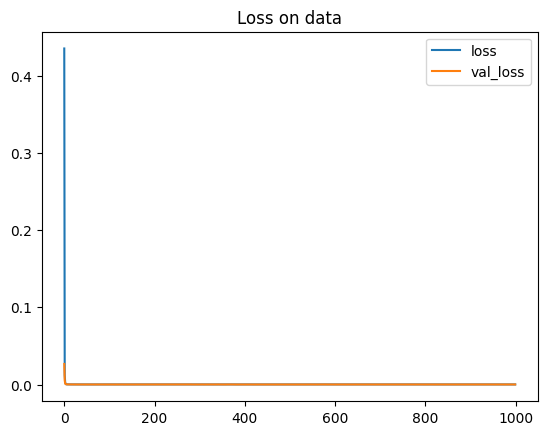

In [13]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [14]:
y_test = sc_y.inverse_transform(y_test.reshape((len(y_test),1)))
y_pred = model.predict(x_test)
y_pred = sc_y.inverse_transform(y_pred.reshape((len(y_pred),1)))

91/91 [==============================] - 1s 9ms/step


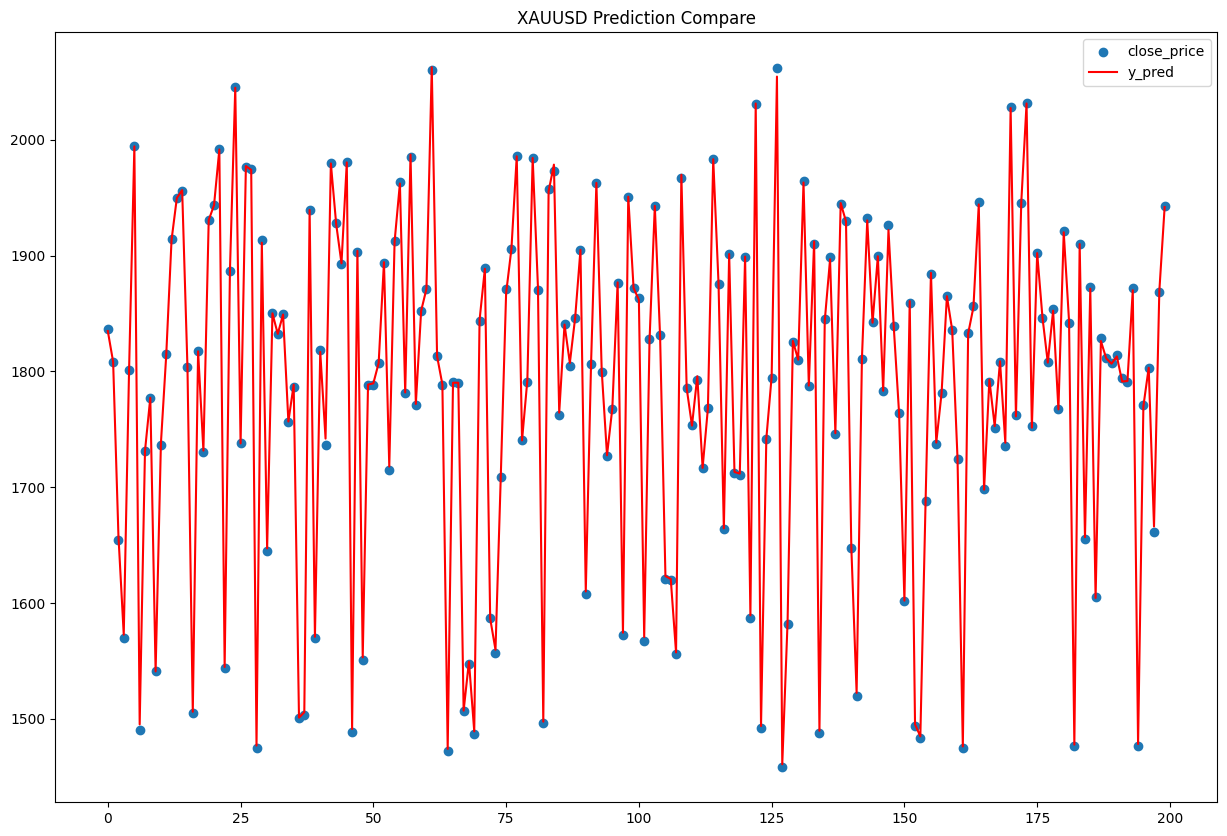

In [15]:
plt.figure(figsize=(15, 10))
plt.title(markets[n]+" Prediction Compare")
x_point = []

for i in range(len(y_test[-200:])):
  t = [i]
  x_point.append(t)
plt.scatter(x_point, y_test[-200:], label="close_price")
#plt.plot(y_test, label="y_test")

plt.plot(y_pred[-200:], label="y_pred", color="red")

plt.legend()

plt.show()

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 512)            1054720   
                                                                 
 lstm_1 (LSTM)               (None, 1, 256)            787456    
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            197120    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65    

In [17]:
model.save(markets[n]+".keras")

In [18]:
import joblib

joblib.dump(sc_x,markets[n]+ ' sc_x.joblib')
joblib.dump(sc_y,markets[n]+ ' sc_y.joblib')

['XAUUSD sc_y.joblib']

: 